### Analysis with the ParlaMint-IT Dataset

Given the large volume of data, this notebook contains a quick exploration of the ParlaMint-IT dataset to understand it better.  

Interactive summary and visualizations for certain metrics, refer to the dashboard.

In [29]:
import os
import gc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from omegaconf import OmegaConf
from utils.file_loader import ParlaMintFileLoader

Load config and samples

In [2]:
PATH_PROJECT = os.getcwd()
config = OmegaConf.load(PATH_PROJECT + "/config.yaml")

# modify for .ipynb
config.paths.conllu = "../parla-parla/data/ParlaMint-IT-en.conllu"
print(f"Config:\n\n{OmegaConf.to_yaml(config)}")


Config:

paths:
  texts: parla-parla\dataset\ParlaMint-IT-en.txt
  conllu: ../parla-parla/data/ParlaMint-IT-en.conllu
topics: null
orientations: null
years: null



In [3]:
loader = ParlaMintFileLoader(config)
df, stats = loader.load_samples()

Processing Files [2013] : 100%|██████████| 158/158.0 [01:40<00:00,  1.57it/s]
Processing Files [2014] : 100%|██████████| 210/210.0 [02:28<00:00,  1.41it/s]
Processing Files [2015] : 100%|██████████| 188/188.0 [02:13<00:00,  1.40it/s]
Processing Files [2016] : 100%|██████████| 180/180.0 [01:53<00:00,  1.58it/s]
Processing Files [2017] : 100%|██████████| 186/186.0 [01:44<00:00,  1.78it/s]
Processing Files [2018] : 100%|██████████| 78/78.0 [01:05<00:00,  1.19it/s]
Processing Files [2019] : 100%|██████████| 101/101.0 [01:36<00:00,  1.05it/s]
Processing Files [2020] : 100%|██████████| 111/111.0 [02:00<00:00,  1.08s/it]
Processing Files [2021] : 100%|██████████| 102/102.0 [01:50<00:00,  1.09s/it]
Processing Files [2022] : 100%|██████████| 74/74.0 [01:05<00:00,  1.13it/s]


In [4]:
print(f"Total files loaded: {stats.files_processed} \nTotal utterances: {stats.tottal_utterances}")

Total files loaded: 1388.0 
Total utterances: 1298209


In [5]:
# change so its more clear
df["Party_orientation"] = df["Party_orientation"].replace("-", "Undefined")
df["Speaker_party"] = df["Speaker_party"].replace("-", "Undefined")

For this task, just keeping the following columns

In [6]:
cols_to_keep = ['sent_id', 'ID_meta', 'text', 'Party_orientation','Words']
df_reduced = df[cols_to_keep]

Segments contain punctuation (don't count as words).

In [7]:
df_punctuation = df_reduced[df_reduced["Words"] == 0]
print(f"Shape: {df_punctuation.shape} \n Example: {df_punctuation.head().text}")

del df_punctuation
gc.collect(); # ; to supress Jupyter output

Shape: (865, 5) 
 Example: 102     .
103     .
2595    .
2609    (
2705    .
Name: text, dtype: object


Remove these samples

In [8]:
df_without_punctuation = df_reduced[df_reduced["Words"] != 0]
print(f"Shape: {df_without_punctuation.shape}")

Shape: (1297344, 5)


Also some text segments may be duplicated

In [9]:
df_without_dup = df_without_punctuation.drop_duplicates("text")

print(f"Shape with duplicates: {df_without_punctuation.shape} \nShape without duplicates {df_without_dup.shape}")

del df_without_punctuation
gc.collect(); # ; to supress Jupyter output

Shape with duplicates: (1297344, 5) 
Shape without duplicates (1061421, 5)


The data segments show the minimum and maximum word counts per segment. 

In [10]:
min(df_without_dup['Words']), max(df_without_dup["Words"])

(1, 481)

On the dashboard, the longest utterance exceeds 9,000 words.

This plot displays the distribution of word counts across segments. A large number of segments outliers are seen with high word counts.

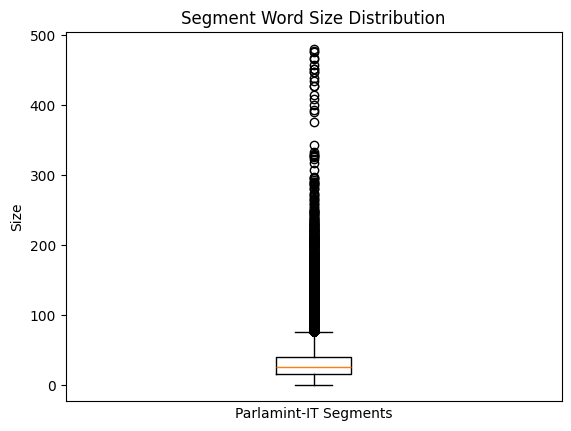

In [11]:
plt.boxplot(df_without_dup.Words.to_numpy())
plt.title("Segment Word Size Distribution")
plt.ylabel("Size")
plt.xlabel("Parlamint-IT Segments")
plt.xticks([])
plt.show()

Segments with only 1–5 words typically consist of short expressions, speaker names, or non-verbal actions.

In [12]:
df_without_dup[df_without_dup["Words"] < 2].head().text

108    CALDEROLI.
121       CASINI.
185        ZANDA.
192        PALMA.
642           No.
Name: text, dtype: object

Setting minimum and maximum thresholds helps reduce the effect of extreme values

In [18]:
MAX_WORDS = 70
MIN_WORDS = 5

In [ ]:
df_thresholded = df_without_dup[(df_without_dup['Words'].gt(MIN_WORDS)) & (df_without_dup['Words'].lt(MAX_WORDS))]
df_thresholded.shape
print(f"Shape without dups.: {df_without_dup.shape} \nShape thresholded {df_thresholded.shape}")

Shape without dups.: (1061421, 5) 
Shape thresholded (984762, 5)


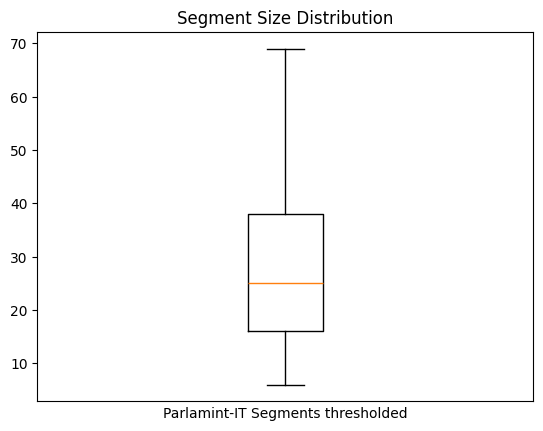

In [20]:
# Matplotlib
plt.boxplot(df_thresholded.Words.to_numpy())
plt.title("Segment Size Distribution")
plt.xlabel("Parlamint-IT Segments thresholded")
plt.xticks([])
plt.show()

The segment word counts are right-skewed

<Axes: ylabel='Density'>

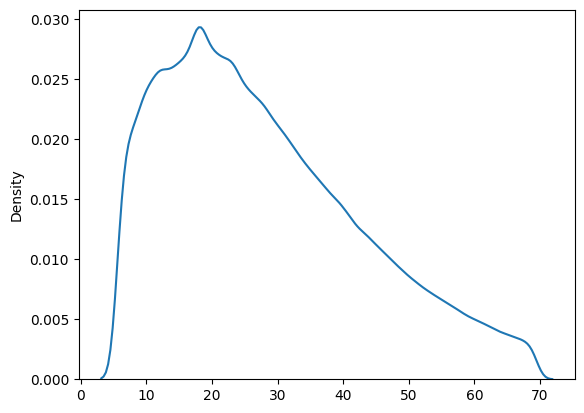

In [35]:
sns.kdeplot(df_thresholded['Words'].to_numpy())

Analysis of the outliers shows that only a small number of segments exceed 100 words.

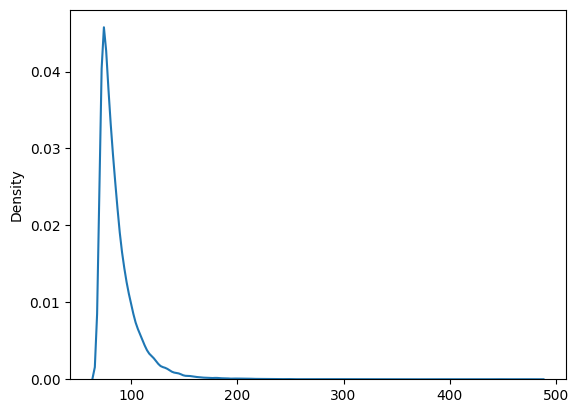

In [38]:
df_outliers = df_without_dup[df_without_dup['Words'].gt(MAX_WORDS)]
sns.kdeplot(df_outliers['Words'].to_numpy())
del df_outliers
gc.collect();

Examining class distribution, some classes like Left have very few samples, while many utterances are undefined, often from mixed political parties.

In [43]:
df_without_dup.groupby(["Party_orientation"]).size()

Party_orientation
Big tent                  173477
Centre                     25021
Centre to centre-left      46518
Centre to centre-right     23354
Centre-left               212335
Centre-left to left         5219
Centre-right              209770
Far-right                   1948
Left                        1606
Right to far-right        188484
Undefined                 173689
dtype: int64

Before thresholding, each party orientation contains some lage amount of outliers.

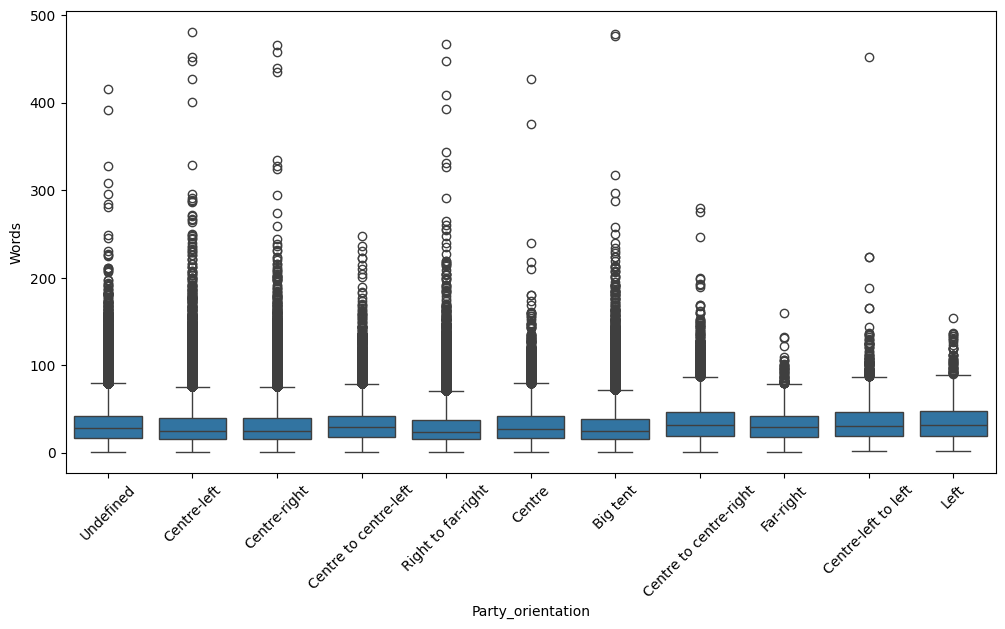

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Party_orientation', y='Words', data=df_without_dup)
plt.xticks(rotation=45)
plt.show()

Applying thresholds reduces the number of outliers in each party orientation

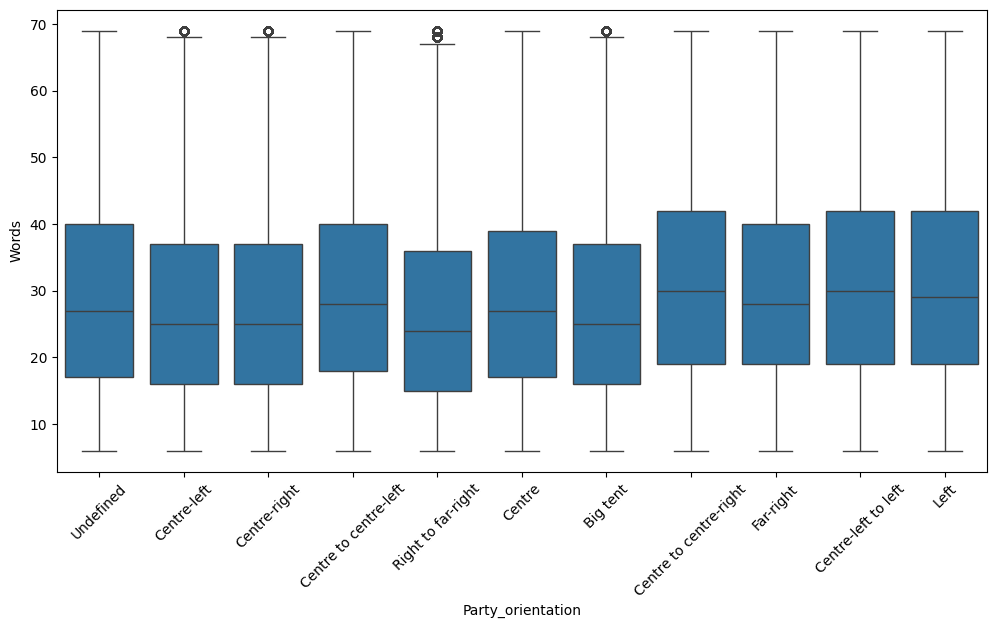

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Party_orientation', y='Words', data=df_thresholded)
plt.xticks(rotation=45)
plt.show()

An idea would be to do some sampling.

In [49]:
df_sampled = df_thresholded.groupby('Party_orientation').apply(lambda x: x.sample(min(len(x), 5000)))

C:\Users\link5\AppData\Local\Temp\ipykernel_17140\4077690357.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_thresholded.groupby('Party_orientation').apply(lambda x: x.sample(min(len(x), 5000)))


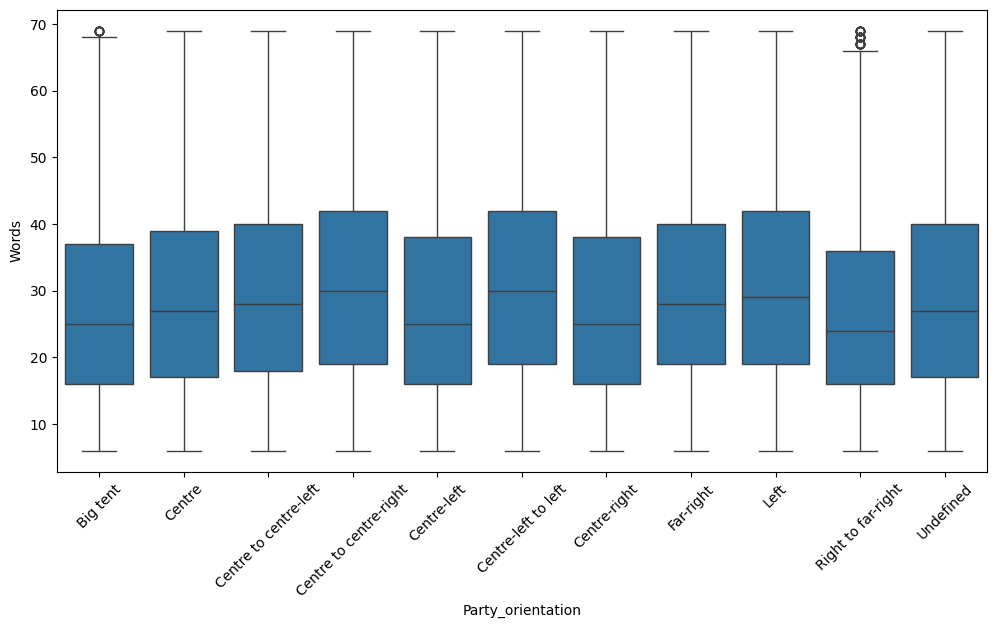

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Party_orientation', y='Words', data=df_sampled)
plt.xticks(rotation=45)
plt.show()